In [65]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')
%matplotlib inline

## data prep

In [2]:
# find your chat.db and establish a connection
conn = sqlite3.connect('/Users/elviswei/Library/Messages/chat.db')
cur = conn.cursor()

# query the database to get all the table names
cur.execute(" select name from sqlite_master where type = 'table' ")

for name in cur.fetchall():
    print(name)

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('sync_deleted_messages',)
('message_processing_task',)
('handle',)
('sync_deleted_chats',)
('message_attachment_join',)
('sync_deleted_attachments',)
('kvtable',)
('chat_message_join',)
('message',)
('chat',)
('attachment',)
('sqlite_stat1',)


In [3]:
# create pandas dataframe with all the tables you care about.

## Mac OSX versions below High Sierra
#messages = pd.read_sql_query('''select *, datetime(date + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date_utc from message''', conn) 

## High Sierra and above
messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date_utc from message''', conn) 

handles = pd.read_sql_query("select * from handle", conn)
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

In [4]:
# these fields are only for ease of datetime analysis (e.g., number of messages per month or year)
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))


# rename the ROWID into message_id, because that's what it is
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)

# rename appropriately the handle and apple_id/phone_number as well
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)


In [ ]:
# merge the messages with the handles
merge_level_1 = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(merge_level_1, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')
df_messages = df_messages[df_messages.handle_id == 156]
df_messages = df_messages[df_messages.text.str[:5] != "Loved"]
df_messages = df_messages[df_messages.text.str[:5] != "Liked"]
df_messages = df_messages[df_messages.text.str[:8] != "Disliked"]
df_messages = df_messages[df_messages.text.str[:10] != "Emphasized"]
df_messages = df_messages[df_messages.text.str[:7] != "Laughed"]
df_messages = df_messages[df_messages.text.str[:10] != "Questioned"]
df_messages = df_messages[df_messages.text.notnull()]
df_messages = df_messages[df_messages.text != '￼']
df_messages = df_messages[df_messages.text != '']


In [72]:
# save the combined table for ease of read for future analysis!
df_messages.to_csv('./imessages_high_sierra.csv', index = False, encoding='utf-8')

## data exploration

In [37]:
df_messages['date'].min(), df_messages['date'].max()

(datetime.date(2021, 3, 26), datetime.date(2021, 12, 10))

(array([737881., 737911., 737942., 737972., 738003., 738034., 738064.,
        738095., 738125.]), <a list of 9 Text xticklabel objects>)

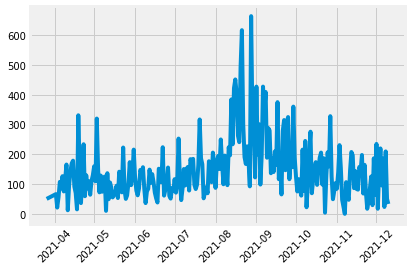

In [48]:
# number of messages per day
plt.plot(df_messages.groupby('date').size())
plt.xticks(rotation='45')

In [49]:
# how many messages you have sent versus received
df_messages.groupby('is_sent').size()

is_sent
0    20385
1    17147
dtype: int64

In [46]:
# number of messages per month and year
df_messages.groupby('month').size()


month
4      285
5      393
6      358
7      524
8     1056
9      287
10     132
11     125
12      45
dtype: int64

and many many many more!

In [42]:
# close connections
cur.close()
conn.close()